In [1]:
# Import libraries
import pandas as pd
import random
import torch as th

# Import Scripts
from Utils import ValidateModel
from Data_loaders import load_batch, User_vocab,Category_vocab,Subcategory_vocab , User_vali, UserData 

/Users/magnusharder/Documents/UNI-DTU/6. Semester/Bachelor Projekt/News-Recommendations/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data contains 17 topics and 264 subtopics


In [2]:
# Load Model
from LSTUR import LSTUR_con
from torch import nn,optim
device = "cpu"
max_history_length = 50


LSTUR_con_module = LSTUR_con(
    seq_len = max_history_length,
    user_dim=300,
    user_size=User_vocab.__len__(),
    topic_size=Category_vocab.__len__(),
    topic_dim=100,
    subtopic_size=Subcategory_vocab.__len__(),
    subtopic_dim=100,
    word_dim=300,
    device=device
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(LSTUR_con_module.parameters(), lr=0.001)

model = LSTUR_con_module.to(device)


In [3]:
Validation = ValidateModel(data_loader = load_batch, data = User_vali, batch_size=100, metrics = ['MRR','ROC_AUC'], device=device,train=False)

Validation.get_metrics(LSTUR_con_module, 10)

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got CPUBoolType instead (while checking arguments for embedding)

In [3]:
BatchSize = 20
batches = 1

model = LSTUR_con_module.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
Softmax = nn.Softmax(dim=1)
Validation = ValidateModel(data_loader = load_batch, data = User_vali, batch_size=BatchSize, metrics = ['MRR','ROC_AUC'], device=device,train=False)

AUC = []
MRR = []
losses = []

for epoch in range(2):

    BatchLoader = load_batch(UserData, batch_size=BatchSize,train = True, device=device)

    for _ in range(batches):
        User_en, Category, Subcategory, History_tensor, history_len, Category_Impressions, Subcategory_Impressions, Impressions_tensor, Impressions_len, Clicked = BatchLoader.__next__()

        optimizer.zero_grad()

        output = model(User_en, Category, Subcategory, History_tensor, history_len, Category_Impressions, Subcategory_Impressions, Impressions_tensor)

        loss = loss_fn(output, Clicked)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())

        print(f'Memory: {th.cuda.memory_reserved()/(10**9)} GB')
        print(loss)
        
    print("Validation")
    Validation = ValidateModel(data_loader = load_batch, data = User_vali, batch_size=BatchSize, metrics = ['MRR','ROC_AUC'], device=device,train=False)
    AUC_score, MRR_score = Validation.get_metrics(model, batches=1)
    print(f'Memory: {th.cuda.memory_reserved()/(10**9)} GB')
    AUC.append(AUC_score)
    MRR.append(MRR_score)





    print(f"AUC: {AUC_score} MRR: {MRR_score}")




Memory: 0.0 GB
tensor(5.7204, grad_fn=<NllLossBackward0>)
Validation
tensor([0.0476, 0.1429, 1.0000, 0.3333, 0.5000, 0.0769, 0.5000, 0.0065, 0.1429,
        0.0556, 0.0270, 0.0455, 0.0667, 0.0065, 0.0476, 0.0051, 0.5000, 0.0052,
        0.2500, 0.1429])
Matrics Batch: AUC: 0.5612026862026862 MRR: 0.19510897994041443
Memory: 0.0 GB
AUC: (0.5612026862026862, tensor(0.1951))
Memory: 0.0 GB
tensor(7.0630, grad_fn=<NllLossBackward0>)
Validation
tensor([0.0036, 0.1667, 0.1667, 0.0909, 0.0034, 0.3333, 0.0714, 0.0071, 0.0093,
        0.0312, 0.0667, 0.1429, 1.0000, 0.1667, 0.0154, 0.1429, 0.2500, 0.2000,
        0.1667, 0.0769])
Matrics Batch: AUC: 0.6203125 MRR: 0.1555880457162857
Memory: 0.0 GB
AUC: (0.6203125, tensor(0.1556))


In [7]:
pred = Softmax(output)

In [63]:
def mean_reciprocal_rank( y_true, y_score):
        N,n_classes = y_score.shape
        order = th.topk(y_score,k=n_classes).indices
        rank = th.take(order,y_true) +1
        rr_score = 1 / rank
        print(rr_score)
        return rr_score.sum()/ N

In [47]:
pred[0][1] > pred[0]

tensor([False, False, False, False, False])

In [34]:
import numpy as np

In [48]:
order = th.topk(pred , 5, dim=1).indices
rank = th.take(Clicked, order)

In [52]:
th.take(order, Clicked)

tensor([4, 0, 3, 1, 1, 0, 1, 4, 4, 4, 3, 2, 2, 3, 3, 3, 2, 1, 3, 4, 1, 0, 4, 4,
        2, 2, 3, 3, 1, 0, 3, 2, 3, 4, 3, 4, 0, 3, 4, 2, 1, 3, 1, 1, 0, 4, 4, 1,
        1, 0, 4, 3, 2, 3, 2, 4, 4, 4, 0, 0, 0, 4, 0, 1, 0, 2, 2, 0, 4, 1, 0, 1,
        2, 3, 3, 2, 2, 1, 4, 4, 2, 1, 4, 3, 4, 1, 0, 1, 4, 4, 3, 1, 2, 3, 3, 3,
        4, 4, 4, 0])

In [64]:
mean_reciprocal_rank(Clicked,pred)

tensor([0.2000, 1.0000, 0.2500, 0.5000, 0.5000, 1.0000, 0.5000, 0.2000, 0.2000,
        0.2000, 0.2500, 0.3333, 0.3333, 0.2500, 0.2500, 0.2500, 0.3333, 0.5000,
        0.2500, 0.2000, 0.5000, 1.0000, 0.2000, 0.2000, 0.3333, 0.3333, 0.2500,
        0.2500, 0.5000, 1.0000, 0.2500, 0.3333, 0.2500, 0.2000, 0.2500, 0.2000,
        1.0000, 0.2500, 0.2000, 0.3333, 0.5000, 0.2500, 0.5000, 0.5000, 1.0000,
        0.2000, 0.2000, 0.5000, 0.5000, 1.0000, 0.2000, 0.2500, 0.3333, 0.2500,
        0.3333, 0.2000, 0.2000, 0.2000, 1.0000, 1.0000, 1.0000, 0.2000, 1.0000,
        0.5000, 1.0000, 0.3333, 0.3333, 1.0000, 0.2000, 0.5000, 1.0000, 0.5000,
        0.3333, 0.2500, 0.2500, 0.3333, 0.3333, 0.5000, 0.2000, 0.2000, 0.3333,
        0.5000, 0.2000, 0.2500, 0.2000, 0.5000, 1.0000, 0.5000, 0.2000, 0.2000,
        0.2500, 0.5000, 0.3333, 0.2500, 0.2500, 0.2500, 0.2000, 0.2000, 0.2000,
        1.0000])


tensor(0.4173)

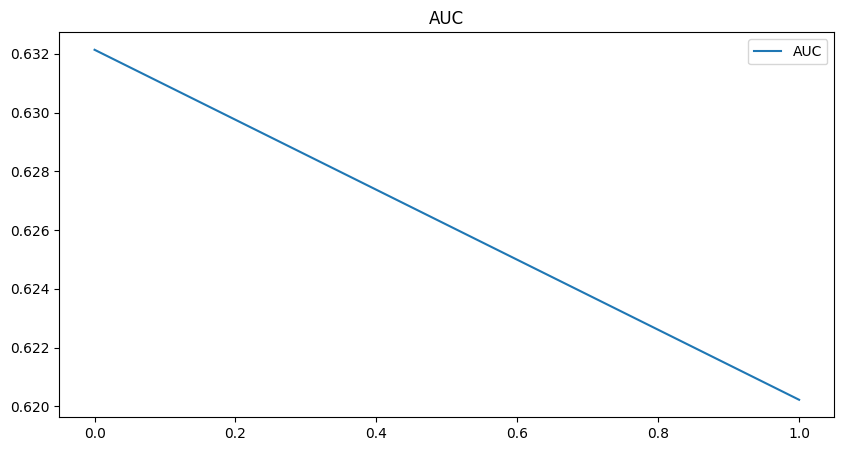

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 5))

axs.plot(AUC, label='AUC')
# axs.plot(losses, label='Loss')
axs.set_title('AUC')
axs.legend()
plt.show()
